In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, vectorize, cuda, njit, float32, int16
import math

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_log(x):
    c = np.log(x)
    return c

a = np.array([2,5,10,3,8]).astype(np.float32)

print(vec_log(a))

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_exp(x):
    c = np.exp(x)
    return c

a = np.array([2,5,10,3,8]).astype(np.float32)

print(vec_exp(a))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

[0.00013383 0.00013386 0.00013389 ... 0.05400392 0.05399745 0.05399097]


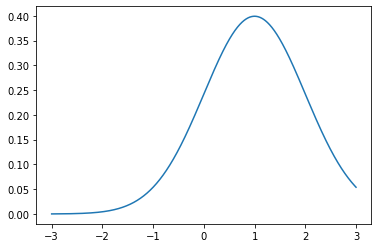

In [3]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_gauss(x):
    c = 1/np.sqrt(2*np.pi) * np.exp(-(x-1)**2/2)
    return c

x = np.linspace(-3, 3, 100000).astype(np.float32)
y = vec_gauss(x)
print(y)
plt.plot(x, y)
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$threshold = 15$

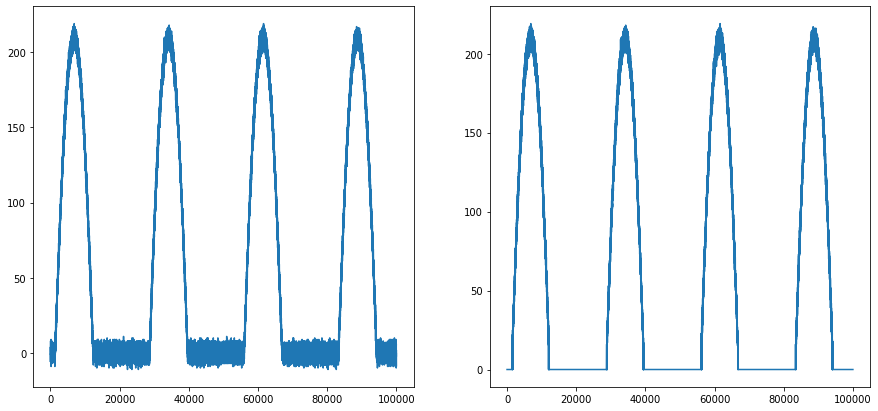

In [4]:
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,7))
ax1.plot(range(n), data)
mag = np.int16(15)

@vectorize([int16(int16, int16)], target='parallel', fastmath=True)
def zero_suppression(x, mag):
    if np.abs(x) < mag:
        c = 0
    else:
        c = x
    return c

data_supp = zero_suppression(data, mag)
ax2.plot(range(n), data_supp)
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [12]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)
K = np.zeros((3,3))
a = 1
c = 0

@cuda.jit
def sigmoid(x, y, k, a, c):
    row, col = cuda.grid(2)
    if row < k.shape[0] and col < k.shape[1]:
        e = 0
        for i in range(x.shape[1]):
            e += x[i][row]*y[i][col]
        k[row][col] = math.tanh(e)

threadsperblock = (32, 32)
blockspergrid_x = int(math.ceil(K.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(K.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

sigmoid[threadsperblock, blockspergrid](X, Y, K, a, c)
print(K)

[[0.88745287 0.76206498 0.62827343]
 [0.52707919 0.35536077 0.30564297]
 [0.75139353 0.52486436 0.48279954]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
@cuda.jit()
def kernel_cos(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = math.cos(io_array[x][y][z]) # do the computation

# Host code   
data = np.pi*np.ones((256, 256, 256))

# Configure the blocks
threadsperblock = (16,8,8) 
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
kernel_cos[blockspergrid, threadsperblock](data)
print(data)

[[[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 ...

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x22$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B"""
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(10, size=(24,12))
B = np.random.randint(10, size=(12, 22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (32, 32)
blockspergrid_x = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)
print(C)

[[127.  88.  71.  94.  84. 124.  98. 111. 107.  72. 116. 137. 148. 141.
  108. 110.  47. 165.  85. 160. 168.  66.]
 [290. 209. 215. 259. 163. 276. 275. 209. 279. 208. 315. 319. 290. 191.
  256. 266. 150. 331. 273. 277. 322. 184.]
 [269. 190. 208. 309. 149. 305. 221. 194. 277. 219. 210. 342. 303. 232.
  257. 306. 176. 261. 214. 338. 280. 212.]
 [260. 208. 164. 195. 150. 207. 256. 156. 255. 178. 216. 277. 247. 211.
  207. 209. 141. 298. 245. 278. 296. 161.]
 [296. 184. 222. 339. 199. 298. 178. 214. 262. 185. 233. 350. 359. 268.
  232. 305. 148. 296. 239. 354. 321. 178.]
 [343. 255. 251. 347. 230. 273. 285. 280. 328. 238. 330. 408. 418. 285.
  289. 355. 217. 411. 367. 395. 439. 174.]
 [266. 205. 200. 258. 209. 272. 160. 200. 241. 144. 196. 295. 308. 272.
  172. 256. 129. 286. 237. 338. 306. 160.]
 [243. 165. 177. 275. 151. 229. 190. 171. 223. 179. 243. 317. 265. 176.
  224. 241. 156. 233. 214. 254. 256. 149.]
 [306. 194. 165. 259. 184. 306. 188. 183. 254.  99. 195. 267. 275. 294.
  176. 2